# Image Segmentation

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
from scipy import sparse
from scipy.sparse import linalg
from scipy import linalg as la
from matplotlib import pyplot as plt
import numpy as np
from scipy import linalg as la
from matplotlib import pyplot as plt
from scipy.sparse import lil_matrix as lil
from scipy.sparse import spdiags
from scipy.sparse import csc_matrix
from scipy.linalg import eig
from scipy.sparse.linalg import eigs as sp_eigs

## Reading the image:

In [3]:
def getImage(filename):
    # Reading the image
    img_color = plt.imread(filename)
    # Brightness is the average of RGB values
    img_brightness = (img_color[:,:,0]+img_color[:,:,1]+img_color[:,:,2])/3
    return img_color,img_brightness

## Finding the neighbours: 

In [4]:
def getNeighbors(index, radius, height, width):
    """
    Objective: Calculate the flattened indices of the pixels that are within the given distance of a central pixel,
    and their distances from the central pixel.

    Parameters:
    index: The index of a central pixel in a flattened image array with original shape (radius, height).
    radius: Radius of the neighborhood around the central pixel.
    height & width: The height & width of the original image in pixels.

    Returns:
    indices: the indices of the pixels that are within the specified 
    radius of the central pixel, with respect to the flattened image.
    distances: the euclidean distances from the neighborhood pixels to
    the central pixel.
    """
    # Find appropriate row, column in unflattened image for flattened index
    row, col = index//width, index%width
    # Cast radius to an int (so we can use arange)
    r = int(radius)
    # Make a square grid of side length 2*r centered at index
    x = np.arange(max(col - r, 0), min(col + r+1, width))
    y = np.arange(max(row - r, 0), min(row + r+1, height))
    X, Y = np.meshgrid(x, y)
    # Narrows down the desired indices using Euclidean norm
    # (i.e. cutting off corners of square to make circle)
    R = np.sqrt(((X-np.float(col))**2+(Y-np.float(row))**2))
    mask = (R<radius)
    indices = X[mask] + Y[mask]*width
    distances = R[mask]
    # Return the indices of flattened array and corresponding distances
    return (indices, distances)


## Creating a weighted adjacency matrix:

In [5]:
# Creating the weighted adjacency matrix 
def adjacency(img_brightness, radius = 5.0, sigma_I = .15, sigma_d = 1.7):
    # Finding height and width of the image
    h, w = img_brightness.shape
    # Flattening the brightness matrix
    bright_flat = img_brightness.flatten()
    n = bright_flat.shape[0]
    # Creating a sparse matrix to store adjacency matrix
    W = sp.sparse.lil_matrix((n,n))
    D = np.zeros(n)
    
    for p in range(n):
        # Finding neighbours for each of the vertices
        indices, distance = getNeighbors(p, radius, w, h)
        # Calculating weight according to equation & assigning to adjacency matrix
        for i in range(len(indices)):
            W[p, int(indices[i])] = np.exp(-(abs(bright_flat[p] - bright_flat[int(indices[i])])
                                             //(sigma_I**2))-(distance[i]//sigma_d**2))
        # Degree matrix element = sum of adjacency matrix row 
        D[p] = W[p].sum()
        
    return W.asformat('csc'), D

## Partioning:

In [6]:
def partitioning(img_brightness, img_color):
    m, n = img_brightness.shape
    # Calling the adjacency function
    A, D = adjacency(img_brightness)
    
    d = 1/np.sqrt(D)
    # Reshaping to align with the original image
    d = sp.sparse.spdiags(d, 0, A.shape[0], A.shape[1])
    D = sp.sparse.spdiags(D, 0, A.shape[0], A.shape[1])
    # Creating the Laplacian matrix
    L = D - A
    
    # D^-1/2 * L * D^-1/2
    c = np.dot(d, L)
    c = np.dot(c, d)
    # Finding 2nd smallest eigenvalue and eigenvector
    e_val, e_vec = sp.sparse.linalg.eigs(c, which='SR') #SR --> Smallest real part
    # Creating the mask
    mask = e_vec[:,1]
    size = mask.shape[0]
    pos, neg = np.zeros(size), np.zeros(size)
    for x in range(size):
        # If eigenvalue is positive
        if mask[x] > 0:
            pos[x] = 1
        # If eigenvalue is negative
        elif mask[x] < 0:
            neg[x] = 1
    # Reshaping to fit image size
    pos = np.reshape(pos, (m,n))
    neg = np.reshape(neg, (m,n))
    pos = np.dstack((pos, pos, pos))
    neg = np.dstack((neg, neg, neg))
    # Finding positive segment of the image
    seg1 = np.multiply(img_color,pos)
    # Finding negative segment of the image
    seg2 = np.multiply(img_color,neg)
    return seg1, seg2, pos, neg

## Displaying the partitioned graph:

In [7]:
# Displays the original, positive & negative segments of the image
def displayPosNeg(img_color,pos,neg):
    plt.subplot(131)
    plt.imshow(img_color)
    plt.subplot(132)
    plt.imshow(neg)
    plt.subplot(133)
    plt.imshow(pos)
    plt.show()

Original image, mask 1 and mask 2:


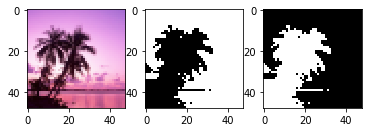

Original image, segment 1 and segment 2:


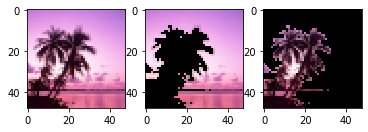

In [8]:
img_color, img_brightness = getImage('dream.png')
seg1, seg2, pos, neg = partitioning(img_brightness, img_color)
# Displaying mask
print("Original image, mask 1 and mask 2:")
displayPosNeg(img_color, pos, neg)
# Displaying mask on image
print("Original image, segment 1 and segment 2:")
displayPosNeg(img_color, seg1, seg2)